#### Variable Selection Techniques
> The purpose of this notebook is to explore various variable selection techniques and how they impact building a regression model. I plan on implementing the following techniques and then comparing their results:
> 1. Stepwise regression
> 2. Lasso
> 3. Elastic net

I am using the US crime dataset used in several of my other analysis so I won't spend time exploring the dataset again. To implement the various variable selection/regularization techniques I plan to use the following steps:
1. Load required data and packages
2. Build a base linear regression model
3. Create new models using all three variable selection/regularization methods
4. Compare all the models

#### Step 1 - Load Data and Packages
First I will load the crime data set and R packages needed for the analysis

In [2]:
# Clear environment
rm(list = ls())

# Set seed so output is reproducible
set.seed(123)

# Load libraries needed for analysis
library(ggplot2) # for plots
library(glmnet) # for Lasso and Elastic Net
library(MASS)
library(caret)

In [3]:
# Load the data
crime_data <- read.table("uscrime.txt", header = TRUE)

# Visually inspect the dataset to make sure everything loaded correctly
head(crime_data)

M,So,Ed,Po1,Po2,LF,M.F,Pop,NW,U1,U2,Wealth,Ineq,Prob,Time,Crime
15.1,1,9.1,5.8,5.6,0.510,95.0,33,30.1,0.108,4.1,3940,26.1,0.084602,26.2011,791
14.3,0,11.3,10.3,9.5,0.583,101.2,13,10.2,0.096,3.6,5570,19.4,0.029599,25.2999,1635
14.2,1,8.9,4.5,4.4,0.533,96.9,18,21.9,0.094,3.3,3180,25.0,0.083401,24.3006,578
13.6,0,12.1,14.9,14.1,0.577,99.4,157,8.0,0.102,3.9,6730,16.7,0.015801,29.9012,1969
14.1,0,12.1,10.9,10.1,0.591,98.5,18,3.0,0.091,2.0,5780,17.4,0.041399,21.2998,1234
12.1,0,11.0,11.8,11.5,0.547,96.4,25,4.4,0.084,2.9,6890,12.6,0.034201,20.9995,682


It is important to use scaled data when performing Lasso and Elastic Net but found that the glmnet() function already standardizes the data so their is no need to do it manually: https://statisticaloddsandends.wordpress.com/2018/11/15/a-deep-dive-into-glmnet-standardize/

#### Step 2 - Create Base Model
I want to create a linear regression model without reducing the variables or using a regularization method for comparison. I'll create the model using the lm() function in the stats package. By putting _{? lm()} into the cell it prints out the documentation for the function which I've started using as a quick way to get info on a new function.

In [4]:
# Create Linear Regression Model and print out the results
options(scipen = 4) # get's rid of scientific notation
crime_base_model <- lm(Crime ~ ., data = crime_data)
coefficients_base <- coef(crime_base_model)

I am going to hold off on evaluating the model until the end, next I'll use the three approaches to build new models for comparison.

#### Step 3 - Build New Models Using Variable Reduction/Regularization Methods
Next I will create new models using stepwise regression, Lasso, and Elastic Net techniques.


##### Model 1 - Stepwise Regression
Stepwise regression is a powerful technique used to build predictive models by iteratively adding or removing variables based on statistical criteria. There are several options for stepwise regression, I plan on performing stepwise regression using the step() function from the stats package. Documentation on the function can be found here: https://www.rdocumentation.org/packages/stats/versions/3.6.2/topics/step. You can set the direction of the selection process using the direction paramater. The uses the AIC value to remove factors but setting k = log(n) makes the function use BIC instead. This this is an exploratory exercise I plan on creating models using forward, backward, and both and a model that uses the BIC to determine factor removal. I put the trace parameter to 0 so the steps each model was taking won't be printed making for a very long homework but I did inspect each of them and will evaluate each of the models at the end.

In [5]:
# Create models using AIC value
sr_both_model <- step(crime_base_model, direction = "both", trace = 0)
sr_back_model <- step(crime_base_model, direction = "backward", trace = 0)
sr_forward_model <- step(crime_base_model, direction = "forward", trace = 0)

# Create models using BIC
sr_bic_model <- step(crime_base_model, direction = "both", k = log(nrow(crime_data)), trace = 0)

In [6]:
# Extract coefficients from each model
coefficients_both <- coef(sr_both_model)
coefficients_back <- coef(sr_back_model)
coefficients_forward <- coef(sr_forward_model)
coefficients_bic <- coef(sr_bic_model)

# Create a data frame to store coefficients
coefficients_df <- data.frame(
  Predictor = c("(Intercept)", colnames(crime_data)[1:15]),
  Both = NA,
  Backward = NA,
  Forward = NA,
  BIC = NA
)

# Fill in coefficients for each model
coefficients_df$Base[coefficients_df$Predictor %in% names(coefficients_base)] <- coefficients_base
coefficients_df$Both[coefficients_df$Predictor %in% names(coefficients_both)] <- coefficients_both
coefficients_df$Backward[coefficients_df$Predictor %in% names(coefficients_back)] <- coefficients_back
coefficients_df$Forward[coefficients_df$Predictor %in% names(coefficients_forward)] <- coefficients_forward
coefficients_df$BIC[coefficients_df$Predictor %in% names(coefficients_bic)] <- coefficients_bic

# Print the coefficients data frame
coefficients_df

Predictor,Both,Backward,Forward,BIC,Base
(Intercept),-6426.10102,-6426.10102,-5984.28760450,-5040.50498,-5984.28760450
M,93.32155,93.32155,87.83017324,105.01957,87.83017324
So,NA,NA,-3.80345030,NA,-3.80345030
Ed,180.12011,180.12011,188.32431475,196.47120,188.32431475
Po1,102.65316,102.65316,192.80433828,115.02419,192.80433828
Po2,NA,NA,-109.42192538,NA,-109.42192538
LF,NA,NA,-663.82614508,NA,-663.82614508
M.F,22.33975,22.33975,17.40685553,NA,17.40685553
Pop,NA,NA,-0.73300815,NA,-0.73300815
NW,NA,NA,4.20446100,NA,4.20446100


Strangly enough, the backward selection and both direction selection arrived at the same model and teh forward selection just recreated the base model.

##### Model 2 - Lasso
Lasso (Least Absolute Shrinkage and Selection Operator) regression is a type of linear regression that incorporates regularization to improve the model's predictive accuracy and interpretability. It achieves this by penalizing the absolute size of the regression coefficients, encouraging some of them to be exactly zero. This property of forcing some coefficients to zero effectively performs variable selection and simplifies the model. I found the picture provided in the lecture helped in understanding the T parameter and how Lasso regression works:
<div style="display: flex; flex-direction: row;">
    <img src="Lasso_Regression.png" alt="Variable Reduction" style="width: 50%;">
    <img src="Lasso_Regression2.png" alt="Variable Regularization" style="width: 50%;">
</div>

Note that the image on the left is when Lasso performs variable selection which happens often vs the image on the right were it is performaning regularization. Lasso regression is based on the T value and reduces the coeffecients of the model until the equation below is met:
\
$$ \sum_{i=1}^{n} |a_j| \leq t_{lasso} 
$$

To perform lasso regression, we’ll use functions from the glmnet package. This package requires the response variable to be a vector and the set of predictor variables to be of the class data.matrix. I am going to use the glmnet() function to fit the lasso regression model with an alpha = 1. Alpha = 0 is equivalent to ridge regression and alpha values beteween 0 and 1 are equivalent to using an elastic net. To determine what value to use for lambda (T value), I am going to perform k-fold cross-validation and identify the T value that produces the lowest test mean squared error (MSE). The default for the cv.glmnet() function is k = 10 folds which I am going to change to the number of datapoints essentially running LOOCV. This provides consistent results and keeps me from having to average error curves. The documentation on cv.glmnet() states "Note also that the results of cv.glmnet are random, since the folds are selected at random. Users can reduce this randomness by running cv.glmnet many times, and averaging the error curves." This is the case despite using the set.seed(123) above. I found this article helpful in creating the Lasso model: https://www.statology.org/lasso-regression-in-r/. Now on to creating the model!

In [17]:
# define the response variable
y <- crime_data$Crime

# define the matrix of predictor variables
x <- data.matrix(crime_data[, -16])

lasso_model <- cv.glmnet(x, y, alpha = 1, nfolds = nrow(crime_data), type.measure = "mse", family = "gaussian", grouped = FALSE)
lasso_lambda <- lasso_model$lambda.min
cat('The best lambda value is:', lasso_lambda)

The best lambda value is: 13.40244

Now that the model is built I will add the coefficients to the coefficient table for the model that corresponds the best lambda value

In [19]:
# Next I'll add the coefficients from the Lasso model to the dataframe
lasso_coef <- coef(lasso_model, s = lasso_lambda)
coefficients_df$Lasso <- lasso_coef[, 1]
coefficients_df <- replace(coefficients_df, coefficients_df == 0, NA)
coefficients_df

Predictor,Both,Backward,Forward,BIC,Base,Lasso,Elastic_Net
(Intercept),-6426.10102,-6426.10102,-5984.28760450,-5040.50498,-5984.28760450,-4315.174518,-5616.39996696
M,93.32155,93.32155,87.83017324,105.01957,87.83017324,64.106051,76.75696101
So,NA,NA,-3.80345030,NA,-3.80345030,49.606315,42.34154807
Ed,180.12011,180.12011,188.32431475,196.47120,188.32431475,95.353431,140.58405032
Po1,102.65316,102.65316,192.80433828,115.02419,192.80433828,104.941252,96.91562486
Po2,NA,NA,-109.42192538,NA,-109.42192538,NA,NA
LF,NA,NA,-663.82614508,NA,-663.82614508,90.100979,NA
M.F,22.33975,22.33975,17.40685553,NA,17.40685553,16.037973,19.99801832
Pop,NA,NA,-0.73300815,NA,-0.73300815,NA,-0.19470688
NW,NA,NA,4.20446100,NA,4.20446100,0.239049,1.61233419


##### Model 3 - Elastic Net
Elastic Net is a regularization technique that combines the penalties of both Lasso (L1 regularization) and Ridge (L2 regularization) regression. It is used to overcome some of the limitations of Lasso and Ridge regression when dealing with high-dimensional data and multicollinearity. Part of creating the Elastic Net model is determining what the alpha parameter so I am going to loop through various alpha paramater values and compare r-squared values for each model.

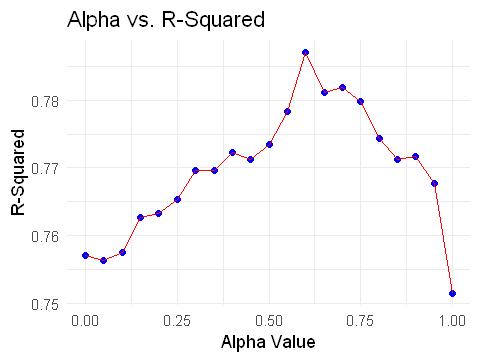

In [20]:
# Create an empty data frame to store results
elastic_r2 <- data.frame(Alpha = numeric(0), R_Squared = numeric(0))

for (i in 0:20) {
  alpha <- i / 20  # Calculate alpha value
  
  # Fit model using leave-one-out cross validation
  model <- cv.glmnet(x, y, type.measure = "mse", alpha = alpha, family = "gaussian", nfold = nrow(x), grouped = FALSE)
  
  # Get R-Squared for best lambda
  r_squared <- model$glmnet.fit$dev.ratio[(model$glmnet.fit$lambda == model$lambda.min)]
  
  # Add row to the data frame
  elastic_r2 <- rbind(elastic_r2, data.frame(Alpha = alpha, R_Squared = r_squared))
}


# Plot the results
options(repr.plot.width=4, repr.plot.height=3)

# Create a scatter plot
ggplot(elastic_r2, aes(x = Alpha, y = R_Squared)) +
    geom_point(color = "blue") +
    geom_line(color = "red") +
    labs(x = "Alpha Value", y = "R-Squared", title = "Alpha vs. R-Squared") +
    theme_minimal()

In [21]:
# Print the alpha value that resulted in the best R_Squared value
max_index <- which.max(elastic_r2[,2])
en_alpha <- elastic_r2[max_index, 1]
elastic_r2[max_index,]

,Alpha,R_Squared
13,0.6,0.7870555


An alpha value of 0.6 provides the best R-Squared value so I am going to recreate the model using that value below and save the coefficients from the model to the coefficients table.

In [22]:
# Create new Elastic Net model using the best Alpha value found above
elastic_net_model = cv.glmnet(x, y, type.measure = "mse", alpha = en_alpha, family = "gaussian", nfold = nrow(x), grouped = FALSE)

# Print out the best lambda value
en_lambda <- elastic_net_model$lambda.min
cat('The best lambda value is:', en_lambda)

The best lambda value is: 8.027647

In [23]:
# Look at the coefficients for the new model
en_coef <- coef(elastic_net_model, s = en_lambda)
coefficients_df$Elastic_Net <- en_coef[, 1]
coefficients_df <- replace(coefficients_df, coefficients_df == 0, NA)
coefficients_df

Predictor,Both,Backward,Forward,BIC,Base,Lasso,Elastic_Net
(Intercept),-6426.10102,-6426.10102,-5984.28760450,-5040.50498,-5984.28760450,-4315.174518,-5616.39996696
M,93.32155,93.32155,87.83017324,105.01957,87.83017324,64.106051,76.75696101
So,NA,NA,-3.80345030,NA,-3.80345030,49.606315,42.34154807
Ed,180.12011,180.12011,188.32431475,196.47120,188.32431475,95.353431,140.58405032
Po1,102.65316,102.65316,192.80433828,115.02419,192.80433828,104.941252,96.91562486
Po2,NA,NA,-109.42192538,NA,-109.42192538,NA,NA
LF,NA,NA,-663.82614508,NA,-663.82614508,90.100979,NA
M.F,22.33975,22.33975,17.40685553,NA,17.40685553,16.037973,19.99801832
Pop,NA,NA,-0.73300815,NA,-0.73300815,NA,-0.19470688
NW,NA,NA,4.20446100,NA,4.20446100,0.239049,1.61233419


#### Step 4 - Analyze the models
Next I want to look how each of the models compare. To do this I am going to calculate the R-Squared value for each model as is and then again using cross-validation. Since the cross validation model created using cv.glmnet() doesn't give me the R^2 value that I want to use to compare the models, I will compute it manually. The formula for the R^2 value is:

$$ R^2 = 1 - (RSS)/(TSS) $$

where RSS is the sum of squares of residuals and TSS is the total sum of squares. I'll calculate the R^2 values for the new models in the loop below.

In [24]:
# Get the Total Sum of Squares
TSS <- sum((crime_data$Crime - mean(crime_data$Crime))^2)

# Get base model R-Squared
base_r2 <- summary(crime_base_model)$r.squared

# Get the stepwise regression models R-Squared values
both_r2 <- summary(sr_both_model)$r.squared
back_r2 <- summary(sr_back_model)$r.squared
forward_r2 <- summary(sr_forward_model)$r.squared
BIC_r2 <- summary(sr_bic_model)$r.squared

# Get Lasso R-Square
lasso_predict <- predict(lasso_model, newx = as.matrix(crime_data[, -16]), s = lasso_lambda)
lasso_RSS <- sum((lasso_predict - crime_data$Crime)^2)
lasso_r2 <- 1 - lasso_RSS / TSS

# Get Elastic Net R-Square
en_predict <- predict(elastic_net_model, newx = as.matrix(crime_data[, -16]), s = en_lambda)
en_RSS <- sum((en_predict - crime_data$Crime)^2)
en_r2 <- 1 - en_RSS / TSS

# Create a data frame to store R-Squared values
r_squared_df <- data.frame(
  Base = base_r2,
  Both = both_r2,
  Backward = back_r2,
  Forward = forward_r2,
  BIC = BIC_r2,
  Lasso = lasso_r2,
  Elastic_Net = en_r2
)

r_squared_df

Base,Both,Backward,Forward,BIC,Lasso,Elastic_Net
0.8030868,0.7888268,0.7888268,0.8030868,0.7658663,0.7515127,0.7870555


Looking at the r-squared values they are all pretty similar. The base model and the forward-selection model have the highest value but also use all of the independent variables. Next I'll calculate the adjusted r-squared to incorporate the number of variables each model uses.

In [25]:
# Get base model Adjusted R-Squared
base_adj_r2 <- summary(crime_base_model)$adj.r.squared

# Get the stepwise regression models Adjusted R-Squared values
both_adj_r2 <- summary(sr_both_model)$adj.r.squared
back_adj_r2 <- summary(sr_back_model)$adj.r.squared
forward_adj_r2 <- summary(sr_forward_model)$adj.r.squared
BIC_adj_r2 <- summary(sr_bic_model)$adj.r.squared

# Get Lasso Adjusted R-Square
lasso_adjustment <- nrow(crime_data) - sum(!is.na(coefficients_df$Lasso))
lasso_adj_r2 <- 1 - ((lasso_RSS/lasso_adjustment) / (TSS/(nrow(crime_data) - 1)))

# Get Elastic Net Adjusted R-Square
en_adjustment <- nrow(crime_data) - sum(!is.na(coefficients_df$Elastic_Net))
en_adj_r2 <- 1 - ((en_RSS/en_adjustment) / (TSS/(nrow(crime_data) - 1)))

# Add values to the r_squred_df
adj_row <- c(base_adj_r2, both_adj_r2, back_adj_r2, forward_adj_r2, BIC_adj_r2, lasso_adj_r2, en_adj_r2)
r_squared_df <- rbind(r_squared_df, adj_row)

# Add row names
rownames(r_squared_df)[1] <- 'R-Sqr'
rownames(r_squared_df)[2] <- 'Adj R-Sqr'

# Print updated dataframe
r_squared_df

,Base,Both,Backward,Forward,BIC,Lasso,Elastic_Net
R-Sqr,0.8030868,0.7888268,0.7888268,0.8030868,0.7658663,0.7515127,0.7870555
Adj R-Sqr,0.7078062,0.7443692,0.7443692,0.7078062,0.7307463,0.6734166,0.7118987


As expected that brought the base model and forward selection models R-Squared value down the most, with the both/backward selection models now having the best values. Next I want to see how the models perform using cross validation. I'll use LOOCV on each of the models that weren't built with cv.glmnet() and pull the cross validated r-squared values directly from the Lasso and Elastic_Net model

In [26]:
# Get R-Squared values using LOOCV
models <- list(crime_base_model, sr_both_model, sr_back_model, sr_forward_model, sr_bic_model)
coefficients <- list(coefficients_base, coefficients_both, coefficients_back, coefficients_forward, coefficients_bic)
cv_r_squared <- numeric(length(models))
cv_adj_r_squared <- numeric(length(models))

# Loop through each of the models and calculate R-Squared using LOOCV
for (i in 1:length(models)) {
    
    # Get the coefficients excluding the intercept
    coefficient_vector <- coefficients[[i]]
    coefficients_no_intercept <- coefficient_vector[!names(coefficient_vector) %in% "(Intercept)"]
    
    # Construct the model formula
    coefficients_str <- paste(names(coefficients_no_intercept), sep = "", collapse = " + ")
    formula_str <- paste("Crime ~", coefficients_str)
    model_formula <- as.formula(formula_str)

    # Set the initial RSS
    RSS <- 0

    # Complete LOOCV updating the RSS value
    for (j in 1:nrow(crime_data)) {
        model <- lm(model_formula, data = crime_data[-j,])
        predictions <- predict(model, newdata = crime_data[j,])
        RSS <- RSS + ((predictions - crime_data[j, 16])^2)
    }

    # Get the new cross-validated R-Squared and Adjusted R-Squared value
    new_r <- 1 - RSS/TSS
    cv_r_squared[i] <- new_r

    model_adjustment <- nrow(crime_data) - length(coefficient_vector)
    adj_r2 <- 1 - ((RSS/model_adjustment) / (TSS/(nrow(crime_data) - 1)))
    cv_adj_r_squared[i] <- adj_r2
}

Next I'll add the LOOCV R-squared values from the Lasson and Elastic Net models and add all of the values to the r_squared_df

In [27]:
en_cv_r_squared <- 1 - elastic_net_model$cvm[which.min(elastic_net_model$cvm)] / var(y)
en_adj_cv_r_squared <- 1- ((elastic_net_model$cvm[which.min(elastic_net_model$cvm)] / (en_adjustment - 1)) / (var(y) / (nrow(crime_data) - 1)))
lasso_cv_r_squared <- 1 - lasso_model$cvm[which.min(lasso_model$cvm)] / var(y)
lasso_adj_cv_r_squared <- 1- ((lasso_model$cvm[which.min(lasso_model$cvm)] / (lasso_adjustment - 1)) / (var(y) / (nrow(crime_data) - 1)))

cv_r_squared <- c(cv_r_squared, en_cv_r_squared, lasso_cv_r_squared)
cv_adj_r_squared <- c(cv_adj_r_squared, en_adj_cv_r_squared, lasso_adj_cv_r_squared)

# Add values to the r_squred_df
r_squared_df <- rbind(r_squared_df, cv_r_squared, cv_adj_r_squared)

# Add row names
rownames(r_squared_df)[3] <- 'LOOCV R-Sqr'
rownames(r_squared_df)[4] <- 'Adj LOOCV R-Sqr'

# Print updated dataframe
r_squared_df

,Base,Both,Backward,Forward,BIC,Lasso,Elastic_Net
R-Sqr,0.8030868,0.7888268,0.7888268,0.8030868,0.7658663,0.7515127,0.7870555
Adj R-Sqr,0.7078062,0.7443692,0.7443692,0.7078062,0.7307463,0.6734166,0.7118987
LOOCV R-Sqr,0.4856070,0.6676210,0.6676210,0.4856070,0.6661638,0.5454841,0.5600290
Adj LOOCV R-Sqr,0.2367071,0.5976464,0.5976464,0.2367071,0.6160884,0.3664323,0.4047451


Looking at the models it is clear that the base/forward models that used all of the variables were severly overfit. The BIC model is performing slightly better than the both/forward selection models when looking at the adjusted R-Squared values. I'm going to print out the coefficients table again for comparison.

In [29]:
# Print out the coefficients dataframe
coefficients_df

Predictor,Both,Backward,Forward,BIC,Base,Lasso,Elastic_Net
(Intercept),-6426.10102,-6426.10102,-5984.28760450,-5040.50498,-5984.28760450,-4315.174518,-5616.39996696
M,93.32155,93.32155,87.83017324,105.01957,87.83017324,64.106051,76.75696101
So,NA,NA,-3.80345030,NA,-3.80345030,49.606315,42.34154807
Ed,180.12011,180.12011,188.32431475,196.47120,188.32431475,95.353431,140.58405032
Po1,102.65316,102.65316,192.80433828,115.02419,192.80433828,104.941252,96.91562486
Po2,NA,NA,-109.42192538,NA,-109.42192538,NA,NA
LF,NA,NA,-663.82614508,NA,-663.82614508,90.100979,NA
M.F,22.33975,22.33975,17.40685553,NA,17.40685553,16.037973,19.99801832
Pop,NA,NA,-0.73300815,NA,-0.73300815,NA,-0.19470688
NW,NA,NA,4.20446100,NA,4.20446100,0.239049,1.61233419


Looking at the adjusted r-squared values calculated using LOOCV, the model created using stepwise regression, using both direction selection, and using BIC as the selection criteria (sr_bic_model) performed the best. It showed less overfitting than all of the other models, especially compared to the base model, and was the simplest model that was created. It uses 6 dependent variables total and while it had the lowest R-Squared value on the training data it was close to the other models. A summary of the model can be seen below.

In [30]:
summary(sr_bic_model)


Call:
lm(formula = Crime ~ M + Ed + Po1 + U2 + Ineq + Prob, data = crime_data)

Residuals:
    Min      1Q  Median      3Q     Max 
-470.68  -78.41  -19.68  133.12  556.23 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -5040.50     899.84  -5.602 1.72e-06 ***
M             105.02      33.30   3.154  0.00305 ** 
Ed            196.47      44.75   4.390 8.07e-05 ***
Po1           115.02      13.75   8.363 2.56e-10 ***
U2             89.37      40.91   2.185  0.03483 *  
Ineq           67.65      13.94   4.855 1.88e-05 ***
Prob        -3801.84    1528.10  -2.488  0.01711 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 200.7 on 40 degrees of freedom
Multiple R-squared:  0.7659,	Adjusted R-squared:  0.7307 
F-statistic: 21.81 on 6 and 40 DF,  p-value: 3.418e-11


The model shows that the Ed, Po1, and Ineq variable shave the largest statistical significance when predicting crime rates in states. This was true for each of the models and including the MF and U1 variables (Both/Backward) only provided a slightly better R-Squared value so probably aren't worth including in the model depending on the objective of it's use.